--- Weather Projection Model Comparison ---
Location: 36.17, -86.78
Fetching data from Open-Meteo...
Training on 74 hours of past data.
Projecting 70 hours into the future.

--- Accuracy Report (vs API Forecast) ---
Linear Regression:    MAE=2.84°C, RMSE=3.24°C
Polynomial (Deg 4):   MAE=481.14°C, RMSE=666.40°C
Note: Lower values indicate the math model matches the weather forecast better.
Displaying accuracy comparison graph...


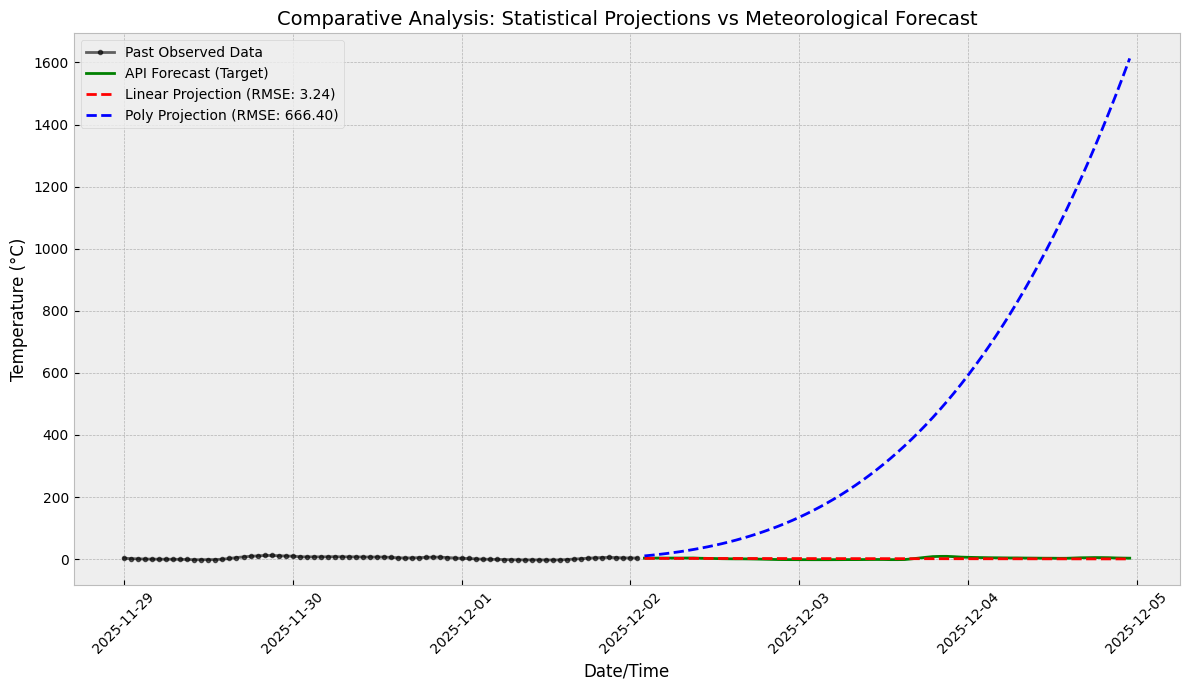

In [3]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import datetime

LATITUDE = 36.17
LONGITUDE = -86.78
PAST_DAYS = 3
FORECAST_DAYS = 3

print("--- Weather Projection Model Comparison ---")
print(f"Location: {LATITUDE}, {LONGITUDE}")

url = (
    f"https://api.open-meteo.com/v1/forecast?"
    f"latitude={LATITUDE}&longitude={LONGITUDE}"
    f"&hourly=temperature_2m"
    f"&past_days={PAST_DAYS}&forecast_days={FORECAST_DAYS}"
    f"&temperature_unit=celsius"
)

try:
    print("Fetching data from Open-Meteo...")
    response = requests.get(url)
    response.raise_for_status()
    data = response.json()
except Exception as e:
    print(f"Error fetching data: {e}")
    exit()

hourly = data['hourly']
df = pd.DataFrame({
    'time': pd.to_datetime(hourly['time']),
    'temp_actual': hourly['temperature_2m']
})

start_time = df['time'].min()
df['seconds'] = (df['time'] - start_time).dt.total_seconds()

current_time_split = datetime.now()
train_df = df[df['time'] < current_time_split].copy()
test_df = df[df['time'] >= current_time_split].copy()

if len(train_df) == 0 or len(test_df) == 0:
    split_idx = int(len(df) * 0.5)
    train_df = df.iloc[:split_idx].copy()
    test_df = df.iloc[split_idx:].copy()

X_train = train_df[['seconds']]
y_train = train_df['temp_actual']
X_test = test_df[['seconds']]
y_test_truth = test_df['temp_actual']

print(f"Training on {len(train_df)} hours of past data.")
print(f"Projecting {len(test_df)} hours into the future.")

lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
test_df['pred_linear'] = lin_model.predict(X_test)

poly_features = PolynomialFeatures(degree=4)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, y_train)
test_df['pred_poly'] = poly_model.predict(X_test_poly)

mae_lin = mean_absolute_error(y_test_truth, test_df['pred_linear'])
rmse_lin = np.sqrt(mean_squared_error(y_test_truth, test_df['pred_linear']))
mae_poly = mean_absolute_error(y_test_truth, test_df['pred_poly'])
rmse_poly = np.sqrt(mean_squared_error(y_test_truth, test_df['pred_poly']))

print("\n--- Accuracy Report (vs API Forecast) ---")
print(f"Linear Regression:    MAE={mae_lin:.2f}°C, RMSE={rmse_lin:.2f}°C")
print(f"Polynomial (Deg 4):   MAE={mae_poly:.2f}°C, RMSE={rmse_poly:.2f}°C")
print("Note: Lower values indicate the math model matches the weather forecast better.")

plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(train_df['time'], train_df['temp_actual'], 'k.-', alpha=0.6, label='Past Observed Data')
ax.plot(test_df['time'], test_df['temp_actual'], 'g-', linewidth=2, label='API Forecast (Target)')
ax.plot(test_df['time'], test_df['pred_linear'], 'r--', label=f'Linear Projection (RMSE: {rmse_lin:.2f})')
ax.plot(test_df['time'], test_df['pred_poly'], 'b--', label=f'Poly Projection (RMSE: {rmse_poly:.2f})')

ax.set_title('Comparative Analysis: Statistical Projections vs Meteorological Forecast', fontsize=14)
ax.set_xlabel('Date/Time')
ax.set_ylabel('Temperature (°C)')
ax.legend()
plt.xticks(rotation=45)
plt.tight_layout()

print("Displaying accuracy comparison graph...")
plt.show()
